Complete the exercises below For **Assignment #6**.

Import the following items,
- `pandas as pd`,
- `LinearRegression` from the [`sklearn.linear_model`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model) module,
- `make_column_transformer` from [`sklearn.compose`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.compose),
- `OneHotEncoder` from [`sklearn.preprocessing`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing),
- `make_pipeline` from the [`sklearn.pipeline`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline) module, and,
- everything from the [plotnine]() package.

In [1]:
import pandas as pd

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from plotnine import *

## Read in our data for this exercise

Use `pd.read_csv` to read in data from the following URL: http://bit.ly/2IgDF0E. Capture the data into a dataframe called `df_voles`.

❗️Hint: just like in `R` we can read data directly from a URL.

In [3]:
df_voles = pd.read_csv('http://bit.ly/2IgDF0E')

In [4]:
df_voles.head()

,site,voles,veg,soil
0,1,17,4,moist
1,2,30,33,moist
2,3,54,94,moist
3,4,49,64,moist
4,5,34,32,moist


Preview the data with the `.head()` method.

The data contains the variables:

- `site` for the id of each random study site (each case or row is a survey/trapping site)
- `voles` for the vole count at each site
- `veg` for the percent cover of vegetation at each site
- `soil` identifying a site as “moist” or “dry”

## EDA

Let's make a few figures from `df_voles` using `ggplot` from **Plotnine**.

In the cell below plot the `voles` variable (y-axis) versus the `veg` variable and color points by the `soil` variable.

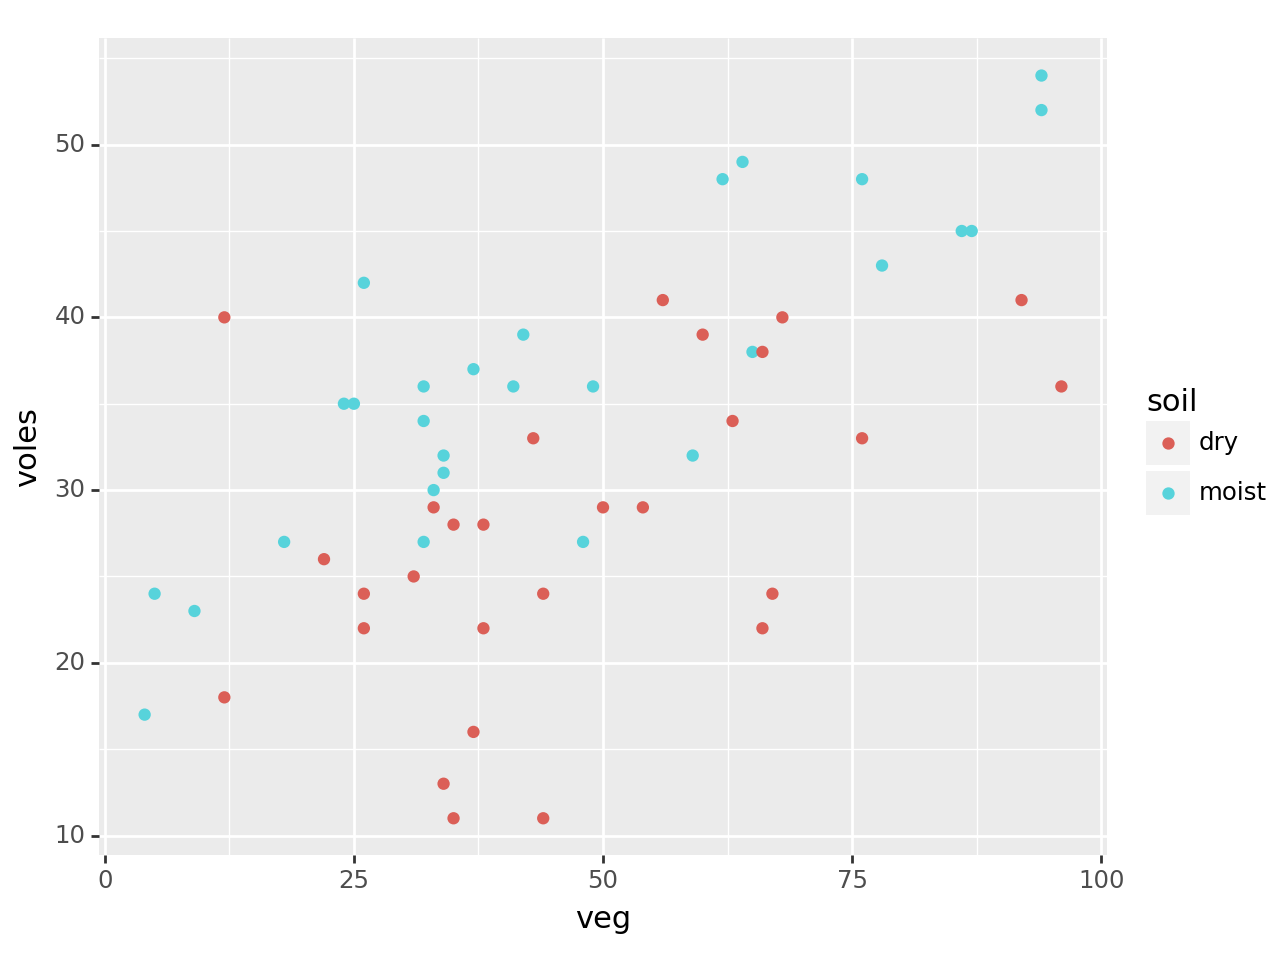

<Figure Size: (640 x 480)>

In [9]:
(ggplot(df_voles, aes(x="veg",y="voles",color="soil"))
+ geom_point()
)

## Modeling

In the cell below, model `voles` with `soil` and `veg` as predictors in a parallel slopes model. 

Here are the steps I would take:
1. Make a column transformer with `make_column_transformer` that transforms `soil` with `OneHotEncoder(drop="first")` and passes 'veg' through untransformed.
2. Create a pipeline with `make_pipeline` using the column transformer from above and `LinearRegression()` as my model. 
3. Get the `X` (training data) and `y` predictor from `df_voles`
4. Use the `.fit()` method for the pipeline to train the model with `X` and `y`. 

Step 1 - Column Transformer

In [22]:
ct = make_column_transformer(
    ['passthrough', ['veg']],
    [OneHotEncoder(drop="first"), ['soil']]
)

Step 2 - Pipeline

In [25]:
pl = make_pipeline(ct,LinearRegression())

Step 3 - Separate Training and Test Data

In [19]:
outcome = 'voles'

# idomatically "X" stands for training data and "y" for the outcome
X, y = df_voles.loc[:, df_voles.columns != outcome], df_voles[outcome]

Step 4 - Train model with X and y

In [26]:
pl.fit(X,y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('passthrough', 'passthrough',
                                                  ['veg']),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first'),
                                                  ['soil'])])),
                ('linearregression', LinearRegression())])

Use the function below to get the parameter values for your model from above.

In [27]:
def get_regression_table(pipeline):
    terms=list(pl['columntransformer'].get_feature_names_out()) + ['intercept']
    mod = pl['linearregression']
    estimates = list(mod.coef_) + [mod.intercept_]
    data = dict(
        term=terms, 
        estimate=estimates,
    )
    return pd.DataFrame(data)

In [28]:
get_regression_table(pl)

,term,estimate
0,passthrough__veg,0.259069
1,onehotencoder__soil_moist,9.100298
2,intercept,15.464026


In [29]:
df_voles_w_pred = df_voles.assign(pred_voles=lambda df_: pl.predict(df_))

In [33]:
df_voles_w_pred.head()

,site,voles,veg,soil,pred_voles
0,1,17,4,moist,25.600600
1,2,30,33,moist,33.113599
2,3,54,94,moist,48.916804
3,4,49,64,moist,41.144736
4,5,34,32,moist,32.854530


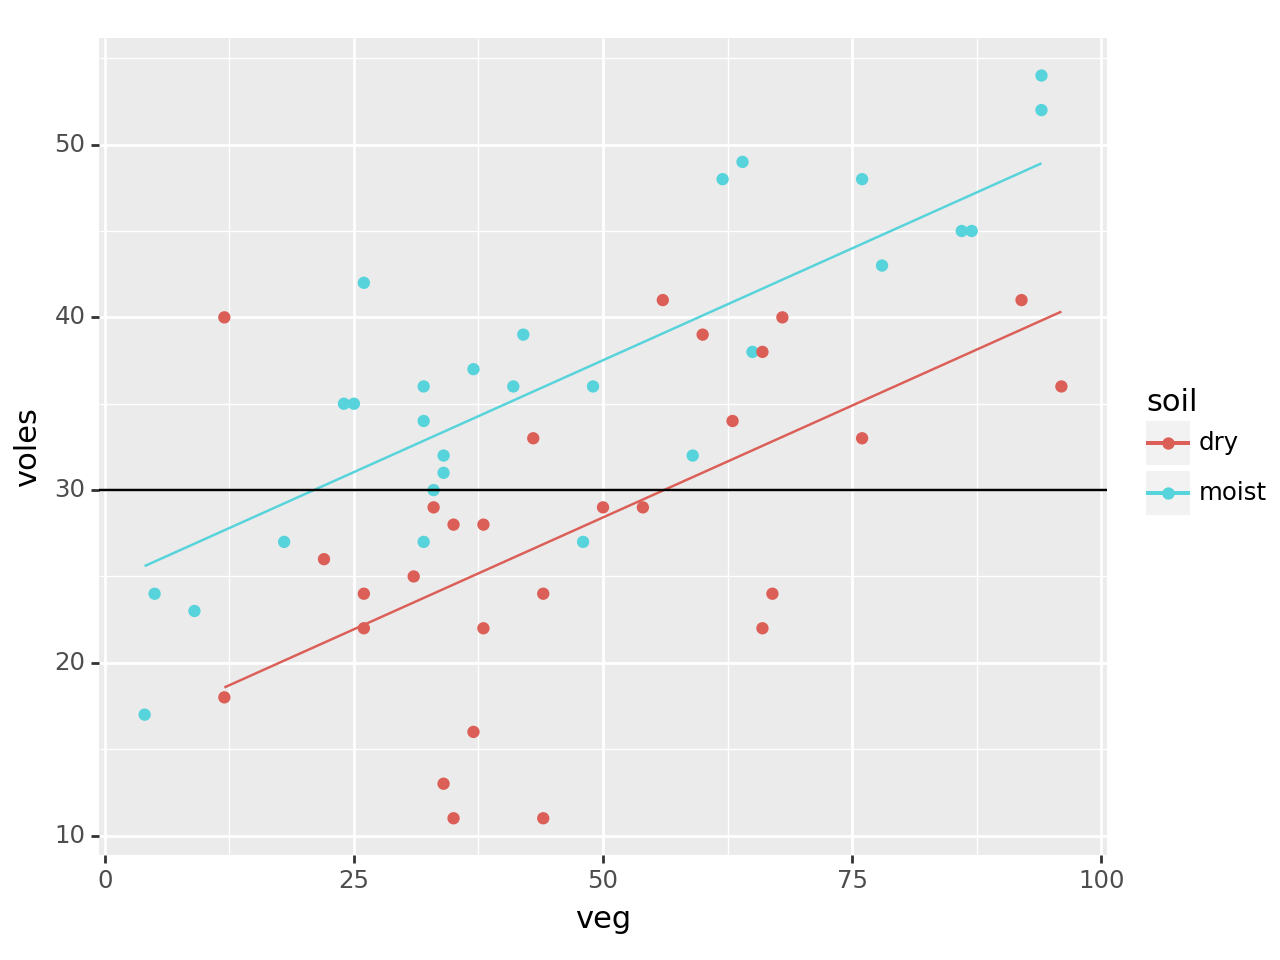

<Figure Size: (640 x 480)>

In [39]:
(ggplot(df_voles_w_pred, aes(x="veg",y="voles",color="soil"))
+ geom_point()
+ geom_line(aes(y="pred_voles"))
+ geom_hline(yintercept=30)
)

❓Would protecting a site with high vegetation cover be a more effective way to preserve the vole population than a site with low vegetation cover? Why?

(**Hint:** use your chart above to answer. It's also possible to leverage your regression parameters if you chose to model `voles` with a parallel slopes model.)

**Answer:**

The model indicates that high vegetation would be more effective. This is indicated by the estimated coefficient of +0.26 for the `veg` variable (.26 additional voles per percent increase in vegetation).

❓Dry sites typically cost a lot less to purchase and maintain for conservation organizations. Thus, if a conservation organization decides to purchase a few dry sites, roughly what percent cover of vegetation do they need to maintain on these sites (at a minimum) to support a population of about 30 voles at the site?

(**Hint:** In your chart above, draw a line at voles = 30 using `geom_hline` and make a rough estimate for this answer...)

**Answer:**

The model estimates that a dry site would need a minimum of approximately 55% ground cover to support 30 voles.

❓The Nature Conservancy is looking at purchasing a site for this species (in the same study area) that has moist soil and 40% vegetation cover. Using the regression equation what would you predict as the possible vole population the site might be able to support?

(**Hint:** Use `.predict(pd.DataFrame({"soil": ["moist"], "veg": [40]}))` with yout pipeline.)

**Answer:**

The model predicts that a site with moist soil and 40% vegetation cover could support 35 voles on average.

In [41]:
pl.predict(pd.DataFrame({"soil":["moist"],"veg":[40]}))

array([34.92708151])